# Fare Price on Uber - Linear Regression
#### dataset: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, cos, sin, asin, sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **Exploratory data analysis**

In [3]:
data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/data/uber.csv")
data.head(3)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1


In [4]:
data.shape

(200000, 9)

##### **Validating features' data type**

In [5]:
data.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [6]:
# the pickup_datetime data type is not appropriate
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])

# let's decompose it to numerical features
data["hour"] = data["pickup_datetime"].dt.hour
data["dayofweek"] = data["pickup_datetime"].dt.dayofweek
data["day"] = data["pickup_datetime"].dt.day
data["month"] = data["pickup_datetime"].dt.month
data["year"] = data["pickup_datetime"].dt.year

In [7]:
data.dtypes

Unnamed: 0                         int64
key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
hour                               int64
dayofweek                          int64
day                                int64
month                              int64
year                               int64
dtype: object

##### **Identifying missing values**

In [8]:
data.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
hour                 0
dayofweek            0
day                  0
month                0
year                 0
dtype: int64

In [9]:
data = data.dropna()

In [10]:
data.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
dayofweek            0
day                  0
month                0
year                 0
dtype: int64

##### **Feature engineering**
###### Extracting a new and useful feature from raw data.

In [11]:
# given two points on a sphere,
# this function determines it"s distance using latitude and longitude

def haversine_formula(lat0, lat1, long0, long1):
    # degrees to radians
    long0 = radians(long0)
    long1 = radians(long1)
    lat0 = radians(lat0)
    lat1 = radians(lat1)
      
    # formula expression
    dlon = long1 - long0
    dlat = lat1 - lat0
    a = sin(dlat / 2)**2 + cos(lat0) * cos(lat1) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # earth radius [km]
    r = 6371
      
    # calculate the result
    return c * r

In [12]:
rides_distance = []

for idx, sample in data.iterrows():
  distance = haversine_formula(sample.pickup_latitude, sample.dropoff_latitude,
                               sample.pickup_longitude, sample.dropoff_longitude)
  
  rides_distance.append(distance)

data["distance"] = rides_distance

##### **Discovering outliers**

In [13]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,199999.0,2.771248e+07,1.601386e+07,1.000000,1.382534e+07,2.774524e+07,4.155535e+07,5.542357e+07
fare_amount,199999.0,1.135989e+01,9.901760e+00,-52.000000,6.000000e+00,8.500000e+00,1.250000e+01,4.990000e+02
pickup_longitude,199999.0,-7.252763e+01,1.143782e+01,-1340.648410,-7.399206e+01,-7.398182e+01,-7.396715e+01,5.741846e+01
pickup_latitude,199999.0,3.993588e+01,7.720558e+00,-74.015515,4.073480e+01,4.075259e+01,4.076716e+01,1.644421e+03
dropoff_longitude,199999.0,-7.252529e+01,1.311741e+01,-3356.666300,-7.399141e+01,-7.398009e+01,-7.396366e+01,1.153573e+03
dropoff_latitude,199999.0,3.992389e+01,6.794829e+00,-881.985513,4.073382e+01,4.075304e+01,4.076800e+01,8.726976e+02
passenger_count,199999.0,1.684543e+00,1.385995e+00,0.000000,1.000000e+00,1.000000e+00,2.000000e+00,2.080000e+02
hour,199999.0,1.349139e+01,6.515505e+00,0.000000,9.000000e+00,1.400000e+01,1.900000e+01,2.300000e+01
dayofweek,199999.0,3.048435e+00,1.946946e+00,0.000000,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
day,199999.0,1.570474e+01,8.687377e+00,1.000000,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01


###### As we can see, the minimum value for **passenger_count**, **distance**, **fare_amount**, **latitude** and **longitude** are not feasible, so let's handle those kind of outliers.

###### What should be considered an outlier:
* `fare_amount < -52` (min value found)
* `130km < distance < 0` (min and maximum ride distance)
* `90 < latitude < -90` (latitude limitation)
* `180 < longitude < -180` (longitude limitation)

In [14]:
features = data.select_dtypes(include=np.number).columns.tolist()
features.remove("Unnamed: 0")

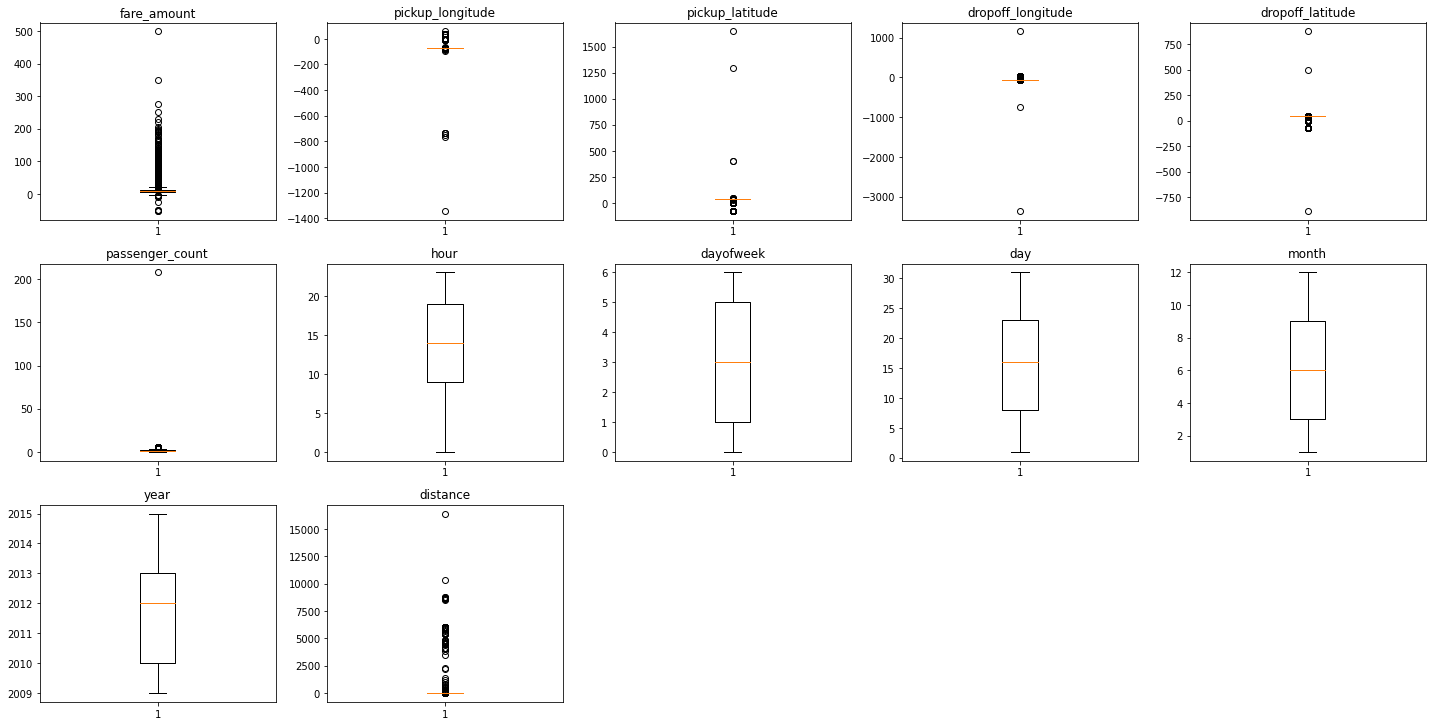

In [15]:
# visualizing outliers with boxplot

plt.figure(figsize=(20, 20))

for idx, feature in enumerate(features):
    plt.subplot(6, 5, idx + 1)
    plt.boxplot(data[feature], whis=1.5)
    plt.tight_layout()
    plt.title(feature)
    
plt.show()

In [16]:
def IQR_rule(column):
    Q1, Q3 = np.percentile(column, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)

    return lower_range, upper_range

In [17]:
for j in features:
    lowerbound, upperbound = IQR_rule(data[j])
    data[j] = np.clip(data[j] , lowerbound , upperbound)

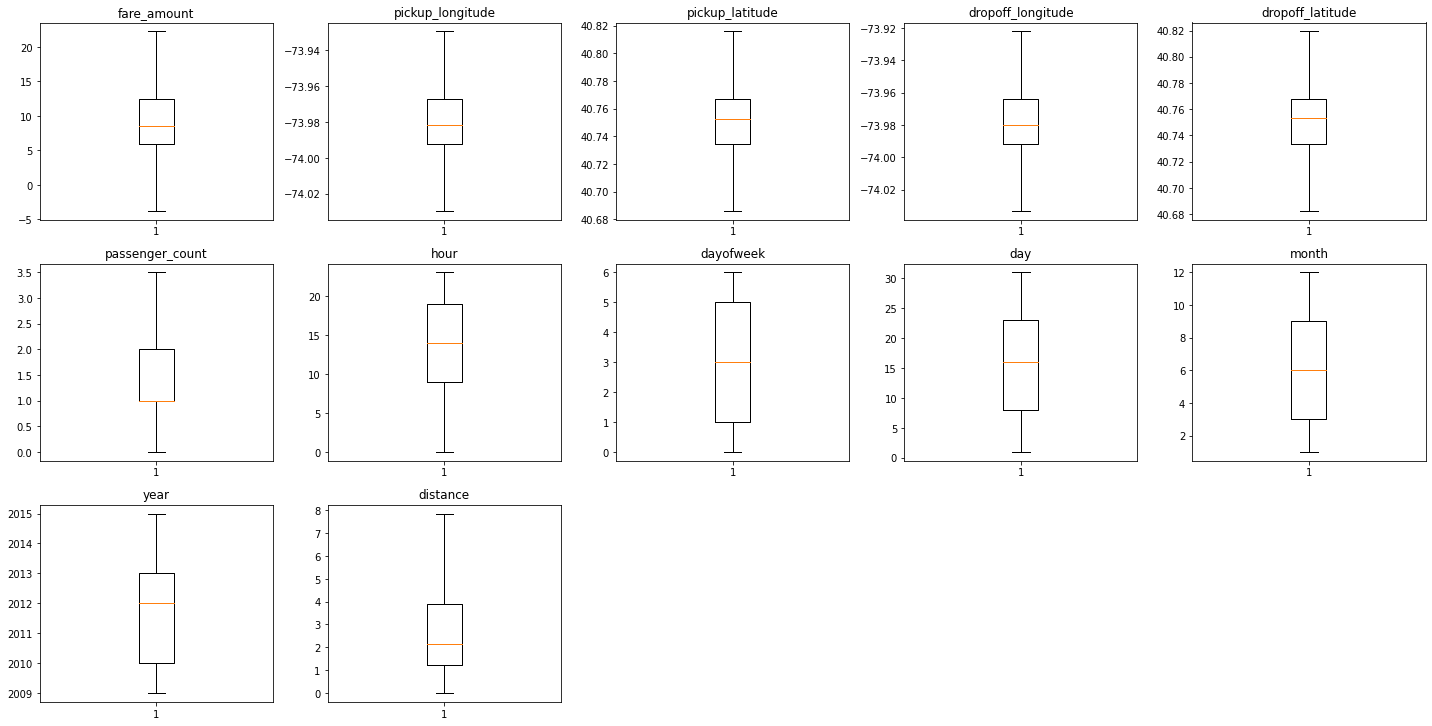

In [18]:
# visualizing outliers with boxplot
# after limiting values

plt.figure(figsize=(20, 20))

for idx, feature in enumerate(features):
    plt.subplot(6, 5, idx + 1)
    plt.boxplot(data[feature], whis=1.5)
    plt.tight_layout()
    plt.title(feature)
    
plt.show()

In [19]:
# removing observations
# without latitude and longitude limitation range

incorrect_coordinates = data.loc[(data.pickup_latitude > 90) | (data.pickup_latitude < -90)
                                  | (data.dropoff_latitude > 90) | (data.dropoff_latitude < -90)
                                  | (data.pickup_longitude > 180) | (data.pickup_longitude < -180)
                                  | (data.dropoff_longitude > 90) | (data.dropoff_longitude < -90)]

data = data.drop(incorrect_coordinates, errors="ignore")

In [20]:
# removing observations
# without distance limitation range

data = data.loc[(data.distance >= 1) | (data.distance <= 130)]

##### **Features correlation**

In [21]:
corr = data.corr()

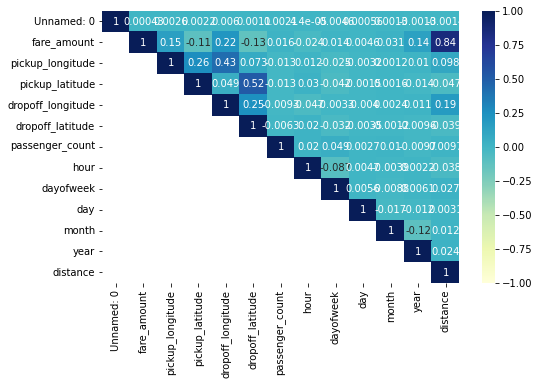

In [22]:
plt.figure(figsize=(8, 5))

mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask, k=-1)] = True

sns.heatmap(corr, cmap="YlGnBu", vmax= 1.0, vmin=-1.0, annot=True, mask=mask)

plt.show()

##### **Distribution of main numerical variables**

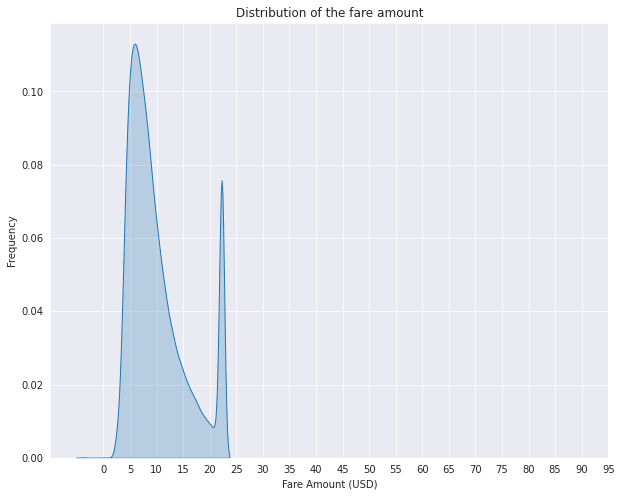

In [23]:
plt.figure(figsize=(10, 8))
sns.set_style("darkgrid")
plt.title("Distribution of the fare amount")
plt.xlabel("Fare Amount (USD)")
plt.ylabel("Frequency")
plt.xlim(-10, 20)
plt.xticks(range(0, 100, 5))

snsplot = sns.kdeplot(data.fare_amount, shade=True)

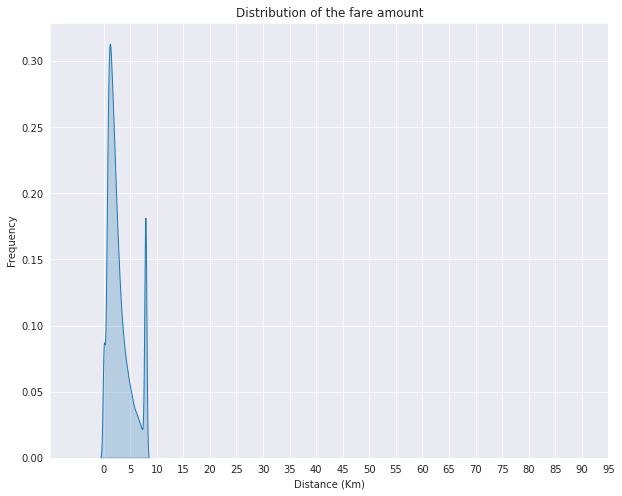

In [24]:
plt.figure(figsize=(10, 8))
sns.set_style("darkgrid")
plt.title("Distribution of the fare amount")
plt.xlabel("Distance (Km)")
plt.ylabel("Frequency")
plt.xlim(-10, 20)
plt.xticks(range(0, 100, 5))

snsplot = sns.kdeplot(data.distance, shade=True)

#### **Model fitting**

In [25]:
data.head(3)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,dayofweek,day,month,year,distance
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0,19,3,7,5,2015,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0,20,4,17,7,2009,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1.0,21,0,24,8,2009,5.036377


In [26]:
data.drop(["Unnamed: 0", "key", "pickup_datetime"], axis=1, inplace=True)

In [27]:
X = data.drop(["fare_amount"], axis=1)
y = data["fare_amount"]

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=33)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((159999, 11), (40000, 11), (159999,), (40000,))

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### **Model prediction**

In [30]:
y_pred = model.predict(X_valid)

#### **Evaluating model**
##### Getting RMSE and R2 metrics

In [31]:
rmse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

In [32]:
print("Slope: ", model.coef_)
print("Intercept: ", model.intercept_)
print("Root mean squared error: ", rmse)
print("R2 score: ", r2)

Slope:  [ 1.69393438e+01 -9.36468872e+00  1.46578604e+01 -1.72725075e+01
  5.35365425e-02  9.24537912e-03 -3.03433982e-02  3.47356766e-03
  5.61947448e-02  3.58954468e-01  2.00216957e+00]
Intercept:  2704.6731432843367
Root mean squared error:  7.343322306266582
R2 score:  0.7503092557034939
